# **Data Collecting**

In [ ]:
!kaggle datasets download -d 'aananehsansiam/audio-dataset-of-scream-and-non-scream'

Dataset URL: https://www.kaggle.com/datasets/aananehsansiam/audio-dataset-of-scream-and-non-scream
License(s): unknown
100% 333M/333M [00:16<00:00, 21.0MB/s]
100% 333M/333M [00:16<00:00, 20.8MB/s]


In [ ]:
pip install tflite-support-nightly

In [ ]:
import os
import zipfile
import librosa
import shutil
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
import soundfile as sf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tflite_support.metadata_writers import audio_classifier
from tflite_support.metadata_writers import metadata_info
from tflite_support.metadata_writers import writer_utils

In [ ]:
zip_files = ['audio-dataset-of-scream-and-non-scream.zip']

for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as dataset_zip:
        dataset_zip.extractall('Data')
        print(f"{zip_file} successfully extracted..")

audio-dataset-of-scream-and-non-scream.zip successfully extracted..


In [ ]:
data_dir = 'Data'

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['Converted_Separately']


# **Exploratory Data Analysis**

In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/Converted_Separately/*/*')
filenames = tf.io.gfile.glob(str(data_dir) + '/*')
filenames = tf.random.shuffle(filenames)
non_scream_files = tf.io.gfile.glob(str(data_dir) + '/Converted_Separately/non_scream/*')
scream_files = tf.io.gfile.glob(str(data_dir) + '/Converted_Separately/scream/*')

In [ ]:
print('Number of examples in Converted_Separately non_scream folder:', len(non_scream_files))
print('Number of examples in Converted_Separately scream folder:', len(scream_files))


Number of examples in Converted_Separately non_scream folder: 1545
Number of examples in Converted_Separately scream folder: 1583


In [ ]:
wav_files = []
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.wav'):
            wav_files.append(os.path.join(root, file))

print(f"Total .wav files found: {len(wav_files)}")

for i, wav_file in enumerate(wav_files[:10]):
    print(f"Processing {i + 1}/{min(10, len(wav_files))}: {wav_file}")
    try:
        audio_data, sample_rate = librosa.load(wav_file, sr=None)
        print(f"  - Audio Shape: {audio_data.shape}")
        print(f"  - Sample Rate: {sample_rate}")
    except Exception as e:
        print(f"  - Error processing file {wav_file}: {e}")

Total .wav files found: 3128
Processing 1/10: Data/Converted_Separately/non_scream/56.wav
  - Audio Shape: (86928,)
  - Sample Rate: 16000
Processing 2/10: Data/Converted_Separately/non_scream/373.wav
  - Audio Shape: (80000,)
  - Sample Rate: 16000
Processing 3/10: Data/Converted_Separately/non_scream/931.wav
  - Audio Shape: (23776,)
  - Sample Rate: 16000
Processing 4/10: Data/Converted_Separately/non_scream/215.wav
  - Audio Shape: (4512,)
  - Sample Rate: 16000
Processing 5/10: Data/Converted_Separately/non_scream/187.wav
  - Audio Shape: (26112,)
  - Sample Rate: 16000
Processing 6/10: Data/Converted_Separately/non_scream/1472.wav
  - Audio Shape: (26192,)
  - Sample Rate: 16000
Processing 7/10: Data/Converted_Separately/non_scream/1062.wav
  - Audio Shape: (31016,)
  - Sample Rate: 16000
Processing 8/10: Data/Converted_Separately/non_scream/469.wav
  - Audio Shape: (24520,)
  - Sample Rate: 16000
Processing 9/10: Data/Converted_Separately/non_scream/969.wav
  - Audio Shape: (200

In [ ]:
classes = ['NotScreaming', 'Screaming']

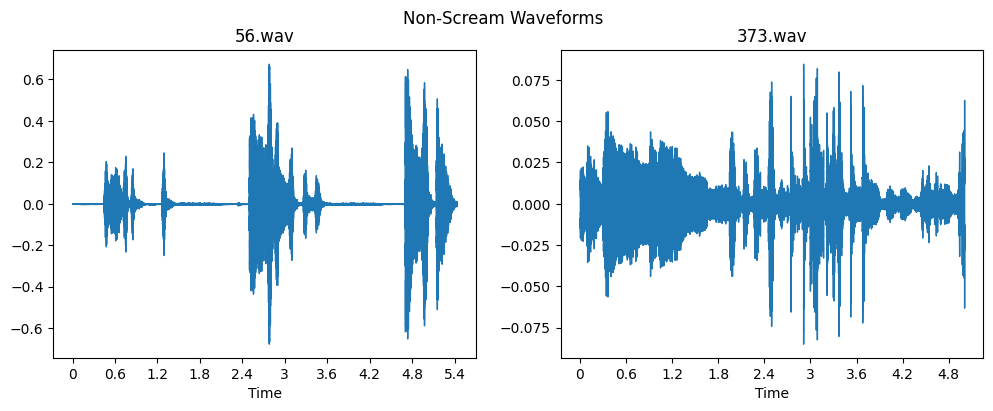

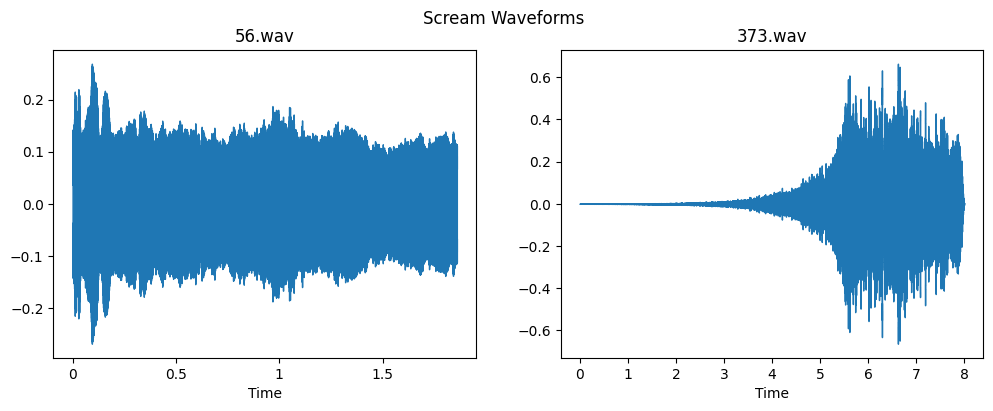

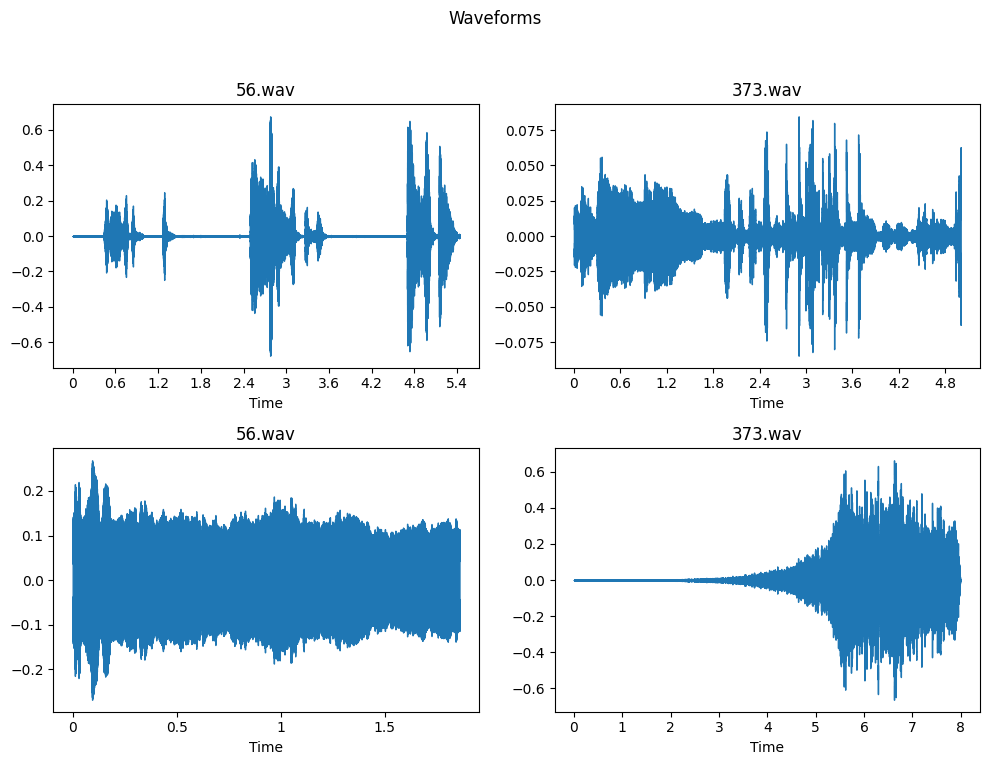

In [ ]:
def plot_waveform(audio_files, num_plots=2, title='Waveform'):
    fig, axes = plt.subplots(1, num_plots, figsize=(12, 4))
    fig.suptitle(title)
    for i in range(num_plots):
        try:
          audio_data, sample_rate = librosa.load(audio_files[i])
          librosa.display.waveshow(audio_data, sr=sample_rate, ax=axes[i])
          axes[i].set_title(os.path.basename(audio_files[i]))
        except Exception as e:
          print(f"Error processing file {audio_files[i]}: {e}")

non_scream_files = non_scream_files[:2]
scream_files = scream_files[:2]

plot_waveform(non_scream_files, title='Non-Scream Waveforms')
plt.show()

plot_waveform(scream_files, title='Scream Waveforms')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Waveforms')

files = non_scream_files + scream_files

for i in range(2):
    for j in range(2):
        idx = i*2 + j
        try:
            audio_data, sample_rate = librosa.load(files[idx])
            librosa.display.waveshow(audio_data, sr=sample_rate, ax=axes[i, j])
            axes[i, j].set_title(os.path.basename(files[idx]))
        except Exception as e:
          print(f"Error processing file {files[idx]}: {e}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

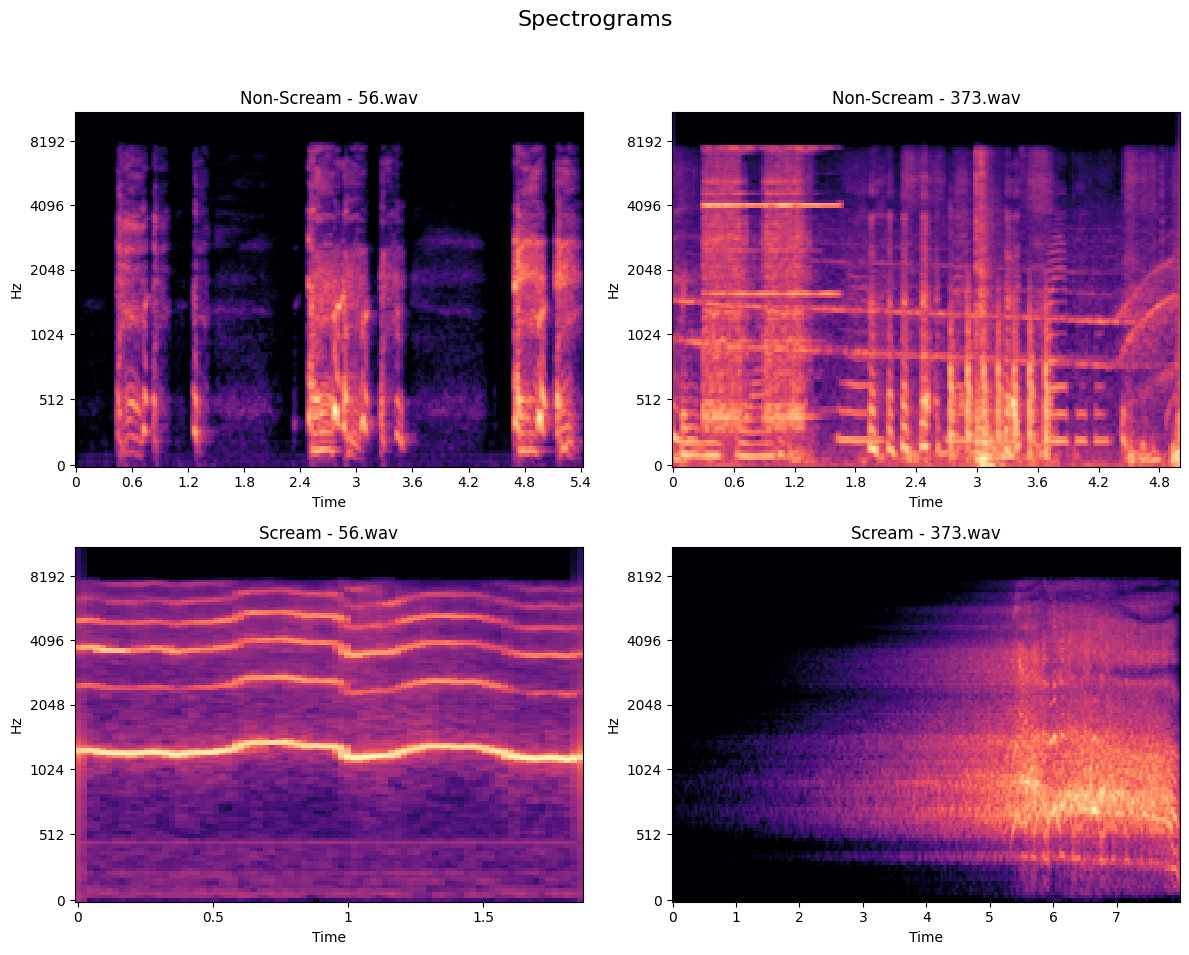

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Spectrograms', fontsize=16)

files = non_scream_files + scream_files
labels = ['Non-Scream'] * 2 + ['Scream'] * 2

for i in range(2):
    for j in range(2):
        idx = i * 2 + j
        try:
            audio_data, sample_rate = librosa.load(files[idx])
            spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
            spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
            librosa.display.specshow(spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel', ax=axes[i, j])
            axes[i, j].set_title(f"{labels[idx]} - {os.path.basename(files[idx])}")
        except Exception as e:
            print(f"Error processing file {files[idx]}: {e}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **Data Preprocessing**

In [ ]:
screaming_path = data_dir+'/Converted_Separately/scream'
non_screaming_path = data_dir+'/Converted_Separately/non_scream'

In [ ]:
def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    return augmented_data

def time_shift(data, shift_max=0.2):
    shift = np.random.randint(int(shift_max * len(data)))
    return np.roll(data, shift)

def augment_audio_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)

            data, sr = librosa.load(file_path)

            augmented_noise = add_noise(data)
            augmented_shift = time_shift(data)

            sf.write(os.path.join(folder_path, f'augmented_noise_{filename}'), augmented_noise, sr)
            sf.write(os.path.join(folder_path, f'augmented_shift_{filename}'), augmented_shift, sr)

In [ ]:
augment_audio_in_folder(screaming_path)
augment_audio_in_folder(non_screaming_path)

In [ ]:
non_screaming_path_source = os.path.join(data_dir, 'Converted_Separately', 'non_scream')
screaming_path_source = os.path.join(data_dir, 'Converted_Separately', 'scream')

non_screaming_path_target = os.path.join(data_dir, 'NotScreaming')
screaming_path_source_target = os.path.join(data_dir, 'Screaming')

In [ ]:
def move_files(source_folder, target_folder):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    for filename in os.listdir(source_folder):
        file_path = os.path.join(source_folder, filename)

        if os.path.isfile(file_path):
            shutil.move(file_path, os.path.join(target_folder, filename))

move_files(non_screaming_path_source, non_screaming_path_target)
move_files(screaming_path_source, screaming_path_source_target)

shutil.rmtree(os.path.join(data_dir, 'Converted_Separately'))

print("The files have been moved and the 'Converted Separately' folder has been deleted.")

The files have been moved and the 'Converted Separately' folder has been deleted.


In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
classes = ['NotScreaming', 'Screaming']
print('Commands:', commands)

Commands: ['Screaming' 'NotScreaming']


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(os.path.join(str(data_dir), str(commands[0])))))
print('Example file tensor:', filenames[0])

Number of total examples: 9384
Number of examples per label: 4749
Example file tensor: tf.Tensor(b'Data/NotScreaming/1193.wav', shape=(), dtype=string)


In [ ]:
def load_and_preprocess_data(data_dir, classes, target_shape=(128, 128)):
    data = []
    labels = []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                audio_data, sample_rate = librosa.load(file_path, sr=None)
                # Convert to Mel spectrogram
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
                # Resize the Mel spectrogram to target shape
                mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
                data.append(mel_spectrogram)
                labels.append(i)

    return np.array(data), np.array(labels)

In [ ]:
# Split data into training and testing sets
data, labels = load_and_preprocess_data(data_dir, classes)
labels = to_categorical(labels, num_classes=len(classes))
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define the neural network model with additional layers
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)

# **Model Training**

In [ ]:
# Add convolutional and pooling layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# Flatten and add dense layers
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(len(classes), activation='softmax')(x)

# Create the model
model = Model(input_layer, output_layer)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,623,682 (17.64 MB)

 Trainable params: 4,623,682 (17.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    min_delta=0.001
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.7280 - loss: 1.8627 - val_accuracy: 0.8455 - val_loss: 0.3548 - learning_rate: 0.0010
Epoch 2/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8823 - loss: 0.3373 - val_accuracy: 0.9141 - val_loss: 0.2169 - learning_rate: 0.0010
Epoch 3/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8938 - loss: 0.3185 - val_accuracy: 0.9201 - val_loss: 0.2140 - learning_rate: 0.0010
Epoch 4/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9218 - loss: 0.2115 - val_accuracy: 0.9414 - val_loss: 0.1838 - learning_rate: 0.0010
Epoch 5/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9407 - loss: 0.1620 - val_accuracy: 0.9421 - val_loss: 0.2018 - learning_rate: 0.0010
Epoch 6/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9393 - loss: 0.1577 - val_accuracy: 0.9427 - val_loss: 0.1817 - learning_rate: 0.0010
Epoch 7/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9491 - loss: 0

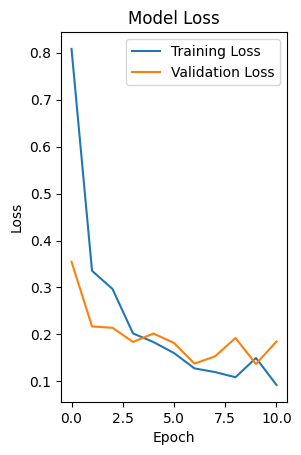

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

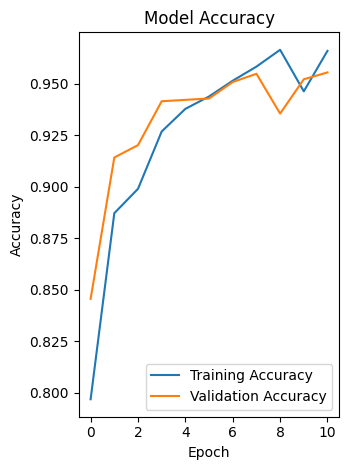

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# **Model Evaluation**

In [ ]:
target_shape = (128, 128)

def test_audio(file_path, model):
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
    mel_spectrogram = tf.reshape(mel_spectrogram, (1,) + target_shape + (1,))

    predictions = model.predict(mel_spectrogram)

    class_probabilities = predictions[0]

    predicted_class_index = np.argmax(class_probabilities)

    return class_probabilities, predicted_class_index

In [ ]:
test_audio_file = data_dir+'/NotScreaming/30.wav'
class_probabilities, predicted_class_index = test_audio(test_audio_file, model)

for i, class_label in enumerate(classes):
    probability = class_probabilities[i]
    print(f'Class: {class_label}, Probability: {probability:.4f}')

predicted_class = classes[predicted_class_index]
accuracy = class_probabilities[predicted_class_index]
print(f'The audio is classified as: {predicted_class}')
print(f'Accuracy: {accuracy:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Class: NotScreaming, Probability: 0.9191
Class: Screaming, Probability: 0.0809
The audio is classified as: NotScreaming
Accuracy: 0.9191


In [ ]:
test_audio_file = data_dir+'/Screaming/45.wav'
class_probabilities, predicted_class_index = test_audio(test_audio_file, model)

for i, class_label in enumerate(classes):
    probability = class_probabilities[i]
    print(f'Class: {class_label}, Probability: {probability:.4f}')

predicted_class = classes[predicted_class_index]
accuracy = class_probabilities[predicted_class_index]
print(f'The audio is classified as: {predicted_class}')
print(f'Accuracy: {accuracy:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Class: NotScreaming, Probability: 0.0000
Class: Screaming, Probability: 1.0000
The audio is classified as: Screaming
Accuracy: 1.0000


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


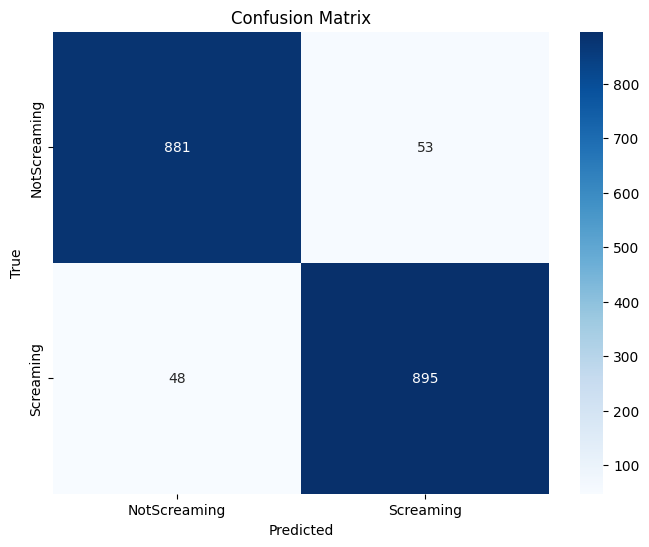

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
results_df = pd.DataFrame({'True Class': y_true, 'Predicted Class': y_pred})
results_df = pd.DataFrame({
    'Predicted_Class': y_pred,
    'True Class': y_true,
    'Probability_Class_0': y_pred_probs[:, 0],
    'Probability_Class_1': y_pred_probs[:, 1],
})

results_df.to_csv('hayak_prediction_results.csv', index=False)

# **Deployment**

In [ ]:
model.save('Hayak_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('Hayak_model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpajr46iow'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  138537147374000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138537156480864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138537156492304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138537156477520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138537156477344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138537156489840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138537156492128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138537130493024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138537130503056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138537130504816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13853713049267

In [ ]:
file_name = "labels.txt"

content = "NotScreaming\nScreaming"

with open(file_name, "w") as file:
    file.write(content)

print(f"File '{file_name}' Success:")
print(content)


File 'labels.txt' Success:
NotScreaming
Screaming


In [ ]:
AudioClassifierWriter = audio_classifier.MetadataWriter
_MODEL_PATH = "Hayak_model.tflite"
_LABEL_FILE = "labels.txt"
_SAMPLE_RATE = 16000
_CHANNELS = 1
_SAVE_TO_PATH = "Hayak_model_metadata.tflite"

writer = AudioClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), _SAMPLE_RATE, _CHANNELS, [_LABEL_FILE])

print(writer.get_metadata_json())

writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "AudioClassifier",
  "description": "Identify the most prominent type in the audio clip from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "audio_clip",
          "description": "Input audio clip to be classified.",
          "content": {
            "content_properties_type": "AudioProperties",
            "content_properties": {
              "sample_rate": 16000,
              "channels": 1
            }
          },
          "stats": {
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "probability",
          "description": "Scores of the labels respectively.",
          "content": {
            "content_properties_type": "FeatureProperties",
            "content_properties": {
            }
          },
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              0.0
            ]
          },
          